A notebook to try fitting FA models with variational inference

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.visualization.utils import enforce_constant_clims

## Parameters go here

In [3]:
d = 10000 # Number of observed variables
m = 5 # Number of latents
n = 5000 # Number of samples

## Generate true model parameters

In [4]:
mu = torch.randn(d)
lam = torch.randn(d,m)
psi_diag = torch.randn(d)**2 + 1

## Generate data

In [5]:
z = torch.randn(n, m)
x = torch.matmul(z, lam.t()) + torch.randn(n,d)*torch.sqrt(psi_diag) + mu

## Fit the model with variational inference

In [6]:
# Setup the observation model P(x|z) = N(\mu + lam*z, psi)

cond_mn_f = torch.nn.Linear(in_features=m, out_features=d, bias=True)
cond_std_f = ConstantBoundedFcn(lower_bound=.001*np.ones(d), 
                                upper_bound=10*np.ones(d),
                                init_value=.1*np.ones(d))
condObsDist = CondGaussianDistribution(mn_f=cond_mn_f, std_f=cond_std_f)

In [7]:
# Setup the variational posterior

In [8]:
class FAVariationalPosterior(torch.nn.Module):
    
    def __init__(self, latent_d: int, n_smps: int):
        """ Creates a new FAVariationalPosterior object. 
        
        Args:
        
            latent_d: Latent dimensionality
            
            n_smps: The number of samples we will calculate posteriors over 
        
        """
        super().__init__()
        
        self.m = latent_d
        self.n = n_smps
        
        #self.mns = torch.nn.Parameter(torch.randn(n_smps, latent_d))
        #self.c = torch.nn.Parameter(torch.randn(latent_d, latent_d))
        self.mns = torch.nn.Parameter(torch.zeros(n_smps, latent_d))
        self.c = torch.nn.Parameter(torch.diag(torch.ones(latent_d)))
        
    def kl(self, inds):
        """ Computes KL divergence between posterior of latent state over a given set of data points and the standard normal.
        
        Args: 
        
            inds: Indices of data points we form the posterior of latent state over. 
            
        Returns:
        
            kl: The kl divergence for the posterior relative to the standard normal
        """
        
        n_kl_data_pts = len(inds)
        
        cov_m = self.c.mm(self.c.T)
        
        cov_trace_sum = n_kl_data_pts*torch.trace(cov_m) 
        m_norm_sum = torch.sum(self.mns[inds]**2)
        m_sum = n_kl_data_pts*self.m
        log_det_sum = n_kl_data_pts*torch.logdet(cov_m)
        
        return .5*(cov_trace_sum + m_norm_sum - m_sum - log_det_sum)
    
    def sample(self, inds):
        """ Samples latent values from the posterior for given data points. """
        
        n_data_pts = len(inds)
        
        return torch.randn(n_data_pts, self.m).mm(self.c.T) + self.mns[inds,:]
        

In [9]:
posterior = FAVariationalPosterior(latent_d=m, n_smps=n)

## Fit the model

In [10]:
batch_size = 100
n_fit_its = 10000

In [11]:
params = list(posterior.parameters()) + list(condObsDist.parameters())
optimizer = torch.optim.Adam(params=params, lr=.01)

In [12]:
for b_i in range(n_fit_its):
    
    optimizer.zero_grad()
    
    # Determine which data points we will fit for
    batch_smp_indices = torch.randperm(n)[0:batch_size]
    
    batch_x = x[batch_smp_indices,:]
    
    # Sample the posteriors over latents for these data points
    batch_post_smps = posterior.sample(batch_smp_indices)
    
    # Calculate the log-likelihood of the observed data given the sampled latents
    log_prob = torch.sum(condObsDist.log_prob(batch_post_smps, batch_x))
    
    # Calculate kl divergence of the posterior for the batch data points and the prior
    kl = posterior.kl(batch_smp_indices)
    
    # Calculate the final objective 
    obj = -log_prob + kl
    
    # Give user some feedback
    if b_i % 1000 == 0:
        print('***** Iteration ' + str(b_i) + ' *****')
        print('NLL: ' + str(log_prob.detach().numpy()))
        print('KL: ' + str(kl.detach().numpy()))
        print('Objective: ' + str(obj.detach().numpy()))
        
    obj.backward()
    optimizer.step()
    

***** Iteration 0 *****
Log Prob: -399335330.0
KL: 0.0
Objective: 399335330.0
***** Iteration 1000 *****
Log Prob: -2580194.5
KL: 1185.4878
Objective: 2581380.0
***** Iteration 2000 *****
Log Prob: -1975559.2
KL: 1563.2065
Objective: 1977122.5
***** Iteration 3000 *****
Log Prob: -1739212.4
KL: 1998.4895
Objective: 1741210.9
***** Iteration 4000 *****
Log Prob: -1693594.6
KL: 2147.6074
Objective: 1695742.2
***** Iteration 5000 *****
Log Prob: -1688104.0
KL: 2155.8374
Objective: 1690259.9
***** Iteration 6000 *****
Log Prob: -1688106.0
KL: 2178.319
Objective: 1690284.4
***** Iteration 7000 *****
Log Prob: -1688098.1
KL: 2139.7234
Objective: 1690237.9
***** Iteration 8000 *****
Log Prob: -1689127.5
KL: 2230.688
Objective: 1691358.2
***** Iteration 9000 *****
Log Prob: -1688346.6
KL: 2173.8545
Objective: 1690520.5


## Examine results of fit

In [13]:
lambda_hat = cond_mn_f.weight.detach()
mu_hat = cond_mn_f.bias.detach().numpy()
psi_diag_hat = cond_std_f(torch.ones(1)).detach().numpy().squeeze()**2

In [14]:
true_cov_str = lam.matmul(lam.T).numpy()
cov_str_hat = lambda_hat.matmul(lambda_hat.T).numpy()

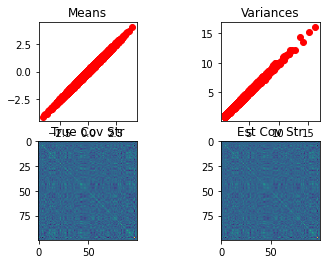

In [15]:
plt.figure()

ax = plt.subplot(2,2,1)
ax.plot(mu, mu_hat, 'ro')
ax.set_aspect('equal', 'box')
plt.title('Means')

ax = plt.subplot(2,2,2)
ax.plot(psi_diag, psi_diag_hat, 'ro')
ax.set_aspect('equal', 'box')
plt.title('Variances')

ax_tc = plt.subplot(2,2,3)
im_tc = ax_tc.imshow(true_cov_str[0:100, 0:100])
plt.title('True Cov Str')

ax_ch =plt.subplot(2,2,4)
im_ch = ax_ch.imshow(cov_str_hat[0:100, 0:100])
plt.title('Est Cov Str')

enforce_constant_clims(ims=[im_tc, im_ch])